## Mixed-effects modeling

In this example we will analyze the reaction time data for the three-by-two task-switching task in the SRO dataset.  Here is a description of the task from the Supplementary Materials of [Enkavi et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6431228/):

>In this task (139, 140) participants respond to colored numbers (1-9) based on their color (orange or blue), magnitude (greater or less than 5), and parity. On each trial a cue informs the participant of the correct rule, which is then applied to make one of two button presses. Each rule has two cues (e.g. "orange-blue" or "color"). Cue words for each rule appear above the stimulus in each trial. On each successive trial the task and cue can stay the same, the task can stay the same and the cue can switch, or the task can switch (necessitating a cue switch). In addition, on task switch trials the task can match the task from two trials ago ("old-task", e.g. "color" -> "parity" -> "color") or differ ("new-task", e.g. "color" -> "parity" -> "magnitude"). Thus there are four trial types which were randomly sampled across trials according to the following probabilities: task-switch-old (33%), task-switch-new (33%), task-stay-cue-switch (16.5%), and task-stay-cue-stay (16.5%). The cue-target-interval (CTI) was short (100ms) for half of the trials and long (900ms) for the other half. Participants complete 60 practice trials and 440 test trials. The dependent measures for this task are the accuracy, median response time and DDM parameters for both all trials as well as for each cue-target-interval condition separately.

> 139. Logan GD, Bundesen C (2003) Clever homunculus: is there an endogenous act of control in the explicit task-cuing procedure? J Exp Psychol Hum Percept Perform 29(3):575–599.

> 140. Mayr U, Kliegl R (2003) Differential effects of cue changes and task changes on task-set selection costs. J Exp Psychol Learn Mem Cogn 29(3):362.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from pymer4.models import Lmer, Lm
from data_utils import get_SRO_data

# set up rpy2
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr

pandas2ri.activate()

%load_ext rpy2.ipython

/Users/poldrack/anaconda3/envs/py37/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


## Prepare the item-level data


In [2]:
switchdata = pd.read_csv('data/SRO/threebytwo.csv.gz', index_col=0)

# remove practice trials
switchdata = switchdata.query('exp_stage == "test"')

# remove implausible response times
switchdata = switchdata.query('rt > 200')

# fix data types - convert to string so that they will be treated as factors
for var in ['CTI']:
    switchdata[var] = [str(i) for i in switchdata[var]]

# add selected variables from main dataset into data frame
SROdata = get_SRO_data(vars=['Age', 'Sex', 'SmokeEveryDay', 'AlcoholHowOften', 'CannabisHowOften'])
SROdata['worker_id'] = SROdata.index
switchdata = switchdata.join(SROdata,on='worker_id', rsuffix='_r')
del switchdata['worker_id_r']
switchdata['smoker'] = switchdata['SmokeEveryDay'] > 2 # "Every day"
switchdata['drinker'] = switchdata['AlcoholHowOften'] > 2 # "2 to 3 times a week"
switchdata['stoner'] = switchdata['CannabisHowOften'] > 3 # daily or almost daily                               

switchdata.columns

Index(['CTI', 'battery_name', 'correct', 'correct_response', 'cue',
       'cue_switch', 'exp_stage', 'experiment_exp_id', 'finishtime',
       'focus_shifts', 'full_screen', 'key_press', 'possible_responses', 'rt',
       'stim_color', 'stim_number', 'stimulus', 'switch_type', 'task',
       'task_switch', 'time_elapsed', 'trial_id', 'trial_num', 'trial_type',
       'worker_id', 'Age', 'Sex', 'SmokeEveryDay', 'AlcoholHowOften',
       'CannabisHowOften', 'smoker', 'drinker', 'stoner'],
      dtype='object')

In [3]:
nsubs = np.unique(switchdata.worker_id).shape[0]
print(f'found {nsubs} unique subjects')
switchdata.CTI.unique()

found 521 unique subjects


array(['900.0', '100.0'], dtype=object)

proportion of RTs greater than 2500 ms: 0.00004


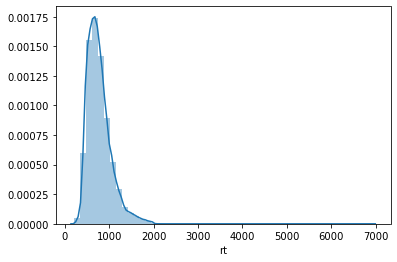

In [4]:
# plot the full distribution of response times

sns.distplot(switchdata.rt)

cutoff = 2500
p_exceed_cutoff = np.mean(switchdata.rt > cutoff)
print(f'proportion of RTs greater than {cutoff} ms: {p_exceed_cutoff:.5f}')

The 2500 ms cutoff excludes very few trials, so let's use that to clean the distribution. 


In [5]:
switchdata = switchdata.query('rt <= 2000')

## Modeling switch costs

The standard approach followed by most researchers for analysis of response times is to first compute the mean for each condition/subject, and then perform a standard linear model on those means.  Let's first do that here.

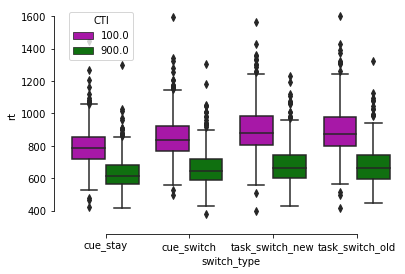

In [6]:
switchdata_by_subject = switchdata.groupby(['worker_id', 'switch_type', 'CTI'])
mean_switchdata_by_subject = switchdata_by_subject.mean().reset_index()

sns.boxplot(x="switch_type", y="rt",
            hue="CTI", palette=["m", "g"],
            data=mean_switchdata_by_subject)
sns.despine(offset=10, trim=True)

Let's fit a standard linear model to these data, using the statsmodels `ols()` function

In [7]:
formula = 'rt ~ 1 + CTI*switch_type'
mod = smf.ols(formula=formula, data=mean_switchdata_by_subject)
res = mod.fit()
mean_switchdata_by_subject['lm_resid'] = mean_switchdata_by_subject.rt - res.predict(mean_switchdata_by_subject, transform=True)

res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rt   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     406.8
Date:                Thu, 09 Apr 2020   Prob (F-statistic):               0.00
Time:                        10:29:57   Log-Likelihood:                -26042.
No. Observations:                4168   AIC:                         5.210e+04
Df Residuals:                    4160   BIC:                         5.215e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                     795.0100      5.486    144.916      0.000     784.254     805.765
CTI[T.900.0]                                 -166.4465      7.758    -21.454      0.000    -181.657    -151.236
switch_type[T.cue_switch]                      56.8187      7.758      7.324      0.000      41.608      72.029
switch_type[T.task_switch_new]                105.7192      7.758     13.626      0.000      90.509     120.930
switch_type[T.task_switch_old]                 97.2117      7.758     12.530      0.000      82.001     112.422
CTI[T.900.0]:switch_type[T.cue_switch]        -23.3989     10.972     -2.133      0.033     -44.910      -1.888
CTI[T.900.0]:switch_type[T.task_switch_new]   -49.4767     10.972     -4.509      0.000     -70.988     -27.966
CTI[T.900.0]:switch_type[T.task_switch_old]   -44.7838     10.972     -4.082      0.000     -66.295     -23.273
==============================================================================
Omnibus:                      605.820   Durbin-Watson:                   0.523
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1389.472
Skew:                           0.843   Prob(JB):                    1.91e-302
Kurtosis:                       5.271   Cond. No.                         12.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
sm.stats.anova_lm(res)

,df,sum_sq,mean_sq,F,PR(>F)
CTI,1.0,3.997287e+07,3.997287e+07,2549.257851,0.000000e+00
switch_type,3.0,4.271619e+06,1.423873e+06,90.807080,6.430440e-57
CTI:switch_type,3.0,4.011983e+05,1.337328e+05,8.528766,1.207204e-05
Residual,4160.0,6.522963e+07,1.568020e+04,NaN,NaN


We see using this model that there are exceedingly significant effects of both switch type and CTI as well as their interaction.  Let's look at the model residuals.

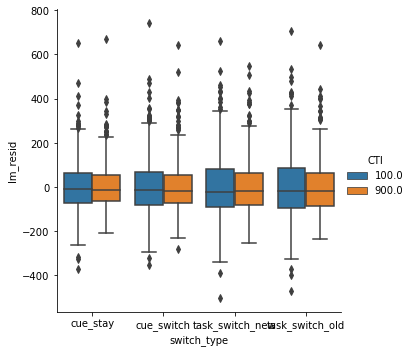

In [9]:
sns.catplot(x='switch_type', y='lm_resid', hue = 'CTI', kind='box', data=mean_switchdata_by_subject)


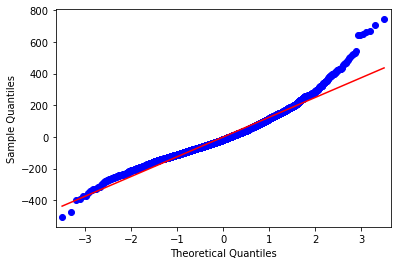

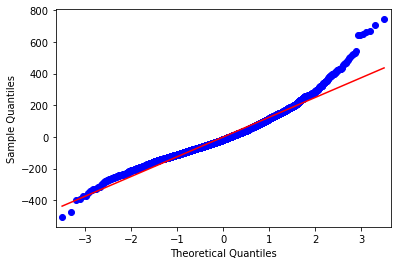

In [10]:
from statsmodels.graphics.gofplots import qqplot
qqplot(mean_switchdata_by_subject['lm_resid'], line='s')

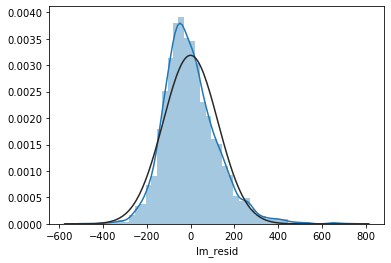

In [11]:
sns.distplot(mean_switchdata_by_subject['lm_resid'], fit=scipy.stats.norm)

These plots suggest that the residuals are not well characterized by a normal distribution.  There are two alternatives; we could either transform the data (e.g. using a log transform), or we could use a generalized linear model with a custom link function that accomodates skewed data. For a large dataset like this, a relatively small excursion from normality should not be a major problem, but we can look at the results using a generalized linear model with a Gamma family for errors.

In [12]:
mod_glm = smf.glm(formula=formula, data=mean_switchdata_by_subject, family=sm.families.Gamma(sm.families.links.log()))
res_glm = mod_glm.fit()
mean_switchdata_by_subject['glm_resid'] = mean_switchdata_by_subject.rt - res_glm.predict(mean_switchdata_by_subject, transform=True)

res_glm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                     rt   No. Observations:                 4168
Model:                            GLM   Df Residuals:                     4160
Model Family:                   Gamma   Df Model:                            7
Link Function:                    log   Scale:                        0.026997
Method:                          IRLS   Log-Likelihood:                -25866.
Date:                Thu, 09 Apr 2020   Deviance:                       107.31
Time:                        10:29:58   Pearson chi2:                     112.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       6.6784      0.007    927.751      0.000       6.664       6.692
CTI[T.900.0]                                   -0.2349      0.010    -23.076      0.000      -0.255      -0.215
switch_type[T.cue_switch]                       0.0690      0.010      6.781      0.000       0.049       0.089
switch_type[T.task_switch_new]                  0.1248      0.010     12.264      0.000       0.105       0.145
switch_type[T.task_switch_old]                  0.1154      0.010     11.332      0.000       0.095       0.135
CTI[T.900.0]:switch_type[T.cue_switch]         -0.0172      0.014     -1.197      0.231      -0.045       0.011
CTI[T.900.0]:switch_type[T.task_switch_new]    -0.0392      0.014     -2.719      0.007      -0.067      -0.011
CTI[T.900.0]:switch_type[T.task_switch_old]    -0.0352      0.014     -2.448      0.014      -0.063      -0.007
===============================================================================================================
"""

In [13]:
res_glm.aic - res.aic

-351.53290822491545

Here we see that the results are very similar to the original model using `lm()`, though the AIC for the generalized linear model is quite a bit lower than for the OLS model.  Since linear models are generally quite robust to non-normality (at least when there are not major outliers), we will stick with the Gausssian family for the remainder of our analyses.

## Mixed effects modeling

In the previous model, we treated our experimental effects as *fixed effects*, meaning that the effect is the same for all individuals.  However, in reality subjects will vary in the size of their effect, meaning that we should actually include the within-subject variability as a factor in our model.  

First, let's run a standard OLS model on each individual subject separately, and store both the parameter for one of the effects of interest (CTI) and the residuals from the model.

In [24]:
subject_ids = np.unique(switchdata.worker_id)

subject_vars = pd.DataFrame(index=subject_ids)
subject_vars['resid_sd'] = 0

formula = 'rt ~ 1 + CTI + switch_type'
switchdata['resid_var'] = 0
switchdata['resid'] = 0
CTI_effect = []
CTI_se = []
for i, sub in enumerate(subject_ids):
    subdata = switchdata.query(f'worker_id == "{sub}"')
    mod = smf.ols(formula=formula, data=subdata)
    res = mod.fit()
    CTI_effect.append(res.params[1])
    CTI_se.append(res.bse[1])
    resid = subdata.rt - res.predict(subdata, transform=True)
    subject_vars.loc[sub, 'resid_sd'] = np.std(resid)
    switchdata.loc[switchdata.worker_id == sub, 'resid_sd'] = np.std(resid)
    switchdata.loc[switchdata.worker_id == sub, 'resid'] = resid

Text(0.5, 0, 'CTI standard deviation')

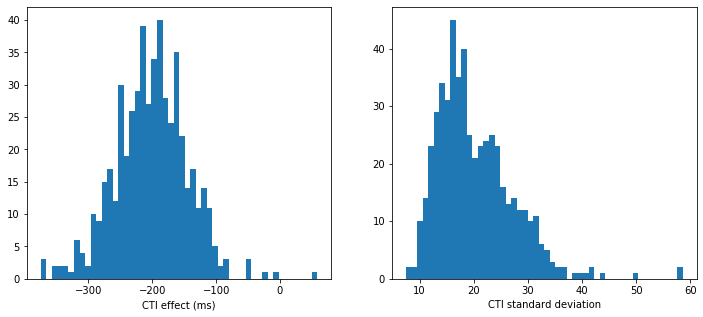

In [26]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
_ = plt.hist(CTI_effect, 50)
plt.xlabel('CTI effect (ms)')
plt.subplot(1,2,2)
_ = plt.hist(CTI_se, 50)
plt.xlabel('CTI standard deviation')


Here we see that the CTI effect varies substantially across subjects, meaning that the assumption of a single parameter value for the population is problematic.  Importantly, the variability of the parameter estimates also varies substantially, which can have an important impact on the results.  If we don't model this, we are assuming *homoscedastiticy* - that is equal variance across individuals.  If that assumption is violated, then the observed test statistics are inflated relative to their true values (Beckmann et al., 2003).  

In the previous model, we collapsed across all trials for each subject.  This is in essence assuming that each subject has the same variance.  Let's look to see how true this is.  For each subject we will fit a model to all of their trials, and then plot the residual variances across subjects:

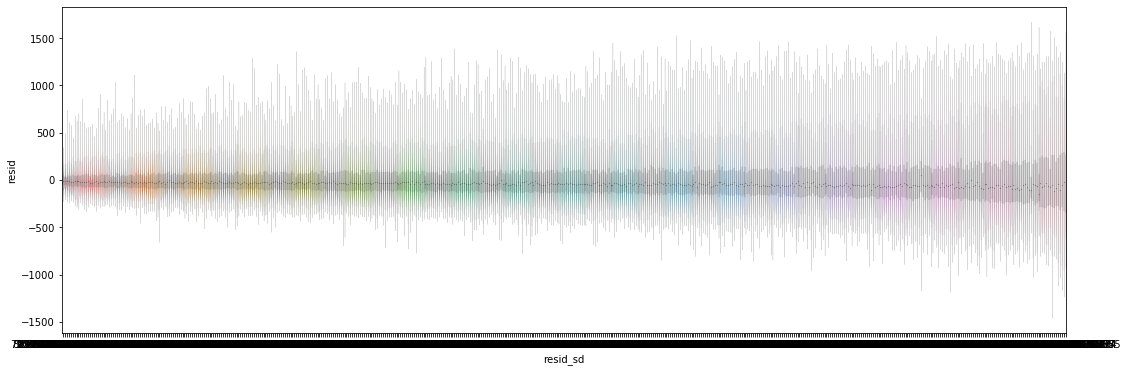

In [24]:
plt.figure(figsize=(18,6))
sns.violinplot(x='resid_sd', y='resid', data=switchdata, linewidth=0.1)

Here we see that there are substantial differences between individuals in both their mean response time and the variability of their response time distributions. Thus, we should use a statistical model that can address these effects.  

Our model also assumed that our effects of interest were fixed

### Fixed vs. random effects

There are various ways to describe the difference between a fixed and a random effect.  In general, a *fixed effect* is one in which our data comprise all of the values of interest for that variable, and for which the values are not determined by random sampling.  For example, in our experiment, we determined the switching conditions, and we wouldn't want to try to generalize to other values of those variables. On the other hand, there are other source of variance in the data for which we would like to generalize.  For example, we used a particular set of stimuli in our study, but we would like to generalize beyond those stimuli to all possible stimuli in a similar task (as we discuss further in the Item Effects example below).  Similarly, we would like to generalize our results to different people.  

We will now look at how to build mixed effects models.  We will use the R "magic" in Jupyter, which allows us to execute R code directly in the notebook and copy variables back and forth between R and python.

In [26]:
# first, let's create new variables that reflect the nested structure
## nonswitch trials include two types: cue-switch and cue-stay
## switch trials include two types: old vs. new task (compared to two trials ago)
switchdata['switch'] = (switchdata['task_switch'] != 'stay').astype('int')
# first fill for nonswitch trials
switchdata['trialtype'] = ['nonswitch_cue_%s' % i for i in switchdata['cue_switch']]
# then fill for switch trials
switchdata.loc[switchdata.switch==1, 'trialtype'] = switchdata.loc[switchdata.switch==1, 'task_switch']

# remove extraneous variables, which were causing problems for pandas2ri
switchdata_for_lmer = switchdata[['rt', 'CTI', 'worker_id', 'cue', 
                                  'switch', 'trialtype', 'Age', 
                                  'smoker', 'drinker', 'stoner',
                                  'trial_num']]

# scale and detrend RT data for each subject
workers = np.unique(switchdata_for_lmer.worker_id)

rt_detrended=np.zeros(switchdata_for_lmer.shape[0])
previous_rt=np.zeros(switchdata_for_lmer.shape[0])

for i, sub in enumerate(workers):
    orig_rt = switchdata_for_lmer.loc[(switchdata_for_lmer.worker_id == sub), 'rt'].copy()
    rt_detrended[(switchdata_for_lmer.worker_id == sub)] = scipy.signal.detrend(orig_rt)
    prev_rt = np.zeros(orig_rt.shape)
    prev_rt[1:] = orig_rt[:-1]
    previous_rt[(switchdata_for_lmer.worker_id == sub)] = prev_rt

switchdata_for_lmer['rt_detrended'] = rt_detrended
switchdata_for_lmer['previous_rt'] = previous_rt

/Users/poldrack/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
%%R -i switchdata_for_lmer

library(lme4)
library(lmerTest)

# since the data are detrended (which also centers at mean zero), we don't need
# a random intercept
lmer_formula = 'rt_detrended ~ 1 + + CTI*trialtype + (0 + CTI*trialtype|worker_id)'
library(optimx)

# this model has trouble converging - we can try various optimizers
# to find one that actually converges

ctrl_nlminb = lmerControl(optimizer ='optimx', optCtrl=list(method='nlminb', maxit = 1e9))
ctrl_lbfgsb = lmerControl(optimizer ='optimx', optCtrl=list(method='L-BFGS-B', maxit = 1e8))
model = lmer(lmer_formula, data=switchdata_for_lmer,
            control = ctrl_nlminb)


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step


R[write to console]: boundary (singular) fit: see ?isSingular

From cffi callback <function _processevents at 0x11c036950>:
Traceback (most recent call last):
  File "/Users/poldrack/anaconda3/envs/py37/lib/python3.7/site-packages/rpy2/rinterface_lib/callbacks.py", line 262, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt
From cffi callback <function _processevents at 0x11c036950>:
Traceback (most recent call last):
  File "/Users/poldrack/anaconda3/envs/py37/lib/python3.7/site-packages/rpy2/rinterface_lib/callbacks.py", line 262, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt
From cffi callback <function _processevents at 0x11

In [ ]:
%%R

s = summary(model)
print(s)

lmer_resid = resid(model)

In [160]:
%%R

anova(model)

                      Sum.Sq     Mean.Sq NumDF       DenDF     F.value
Age                 171947.9   171947.93     1    254.3588    3.784701
CTI               49741663.9 49741663.87     1 222495.3065 1094.850652
trialtype          6231766.4  2077255.47     3 222485.8246   45.721923
Age:CTI            9113017.5  9113017.54     1 222493.9333  200.584227
Age:trialtype       465011.4   155003.78     3 222488.3135    3.411747
CTI:trialtype       159516.4    53172.12     3 222485.9741    1.170358
Age:CTI:trialtype   428331.4   142777.14     3 222486.8634    3.142630
                         Pr..F.
Age                5.282485e-02
CTI               1.667880e-239
trialtype          1.576059e-29
Age:CTI            1.629890e-45
Age:trialtype      1.667040e-02
CTI:trialtype      3.193314e-01
Age:CTI:trialtype  2.411295e-02


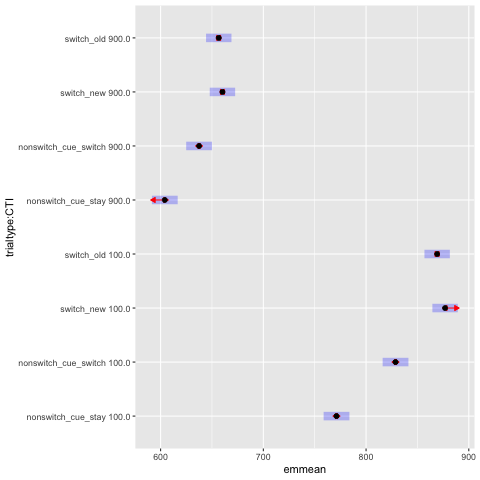

In [161]:
%%R

emm = emmeans(model, pairwise ~ trialtype*CTI)
plot(emm, comparisons = TRUE)

## Independence

One of the assumptions of the model is that errors are independent, conditional on the model structure.  


In [146]:
from sklearn.linear_model import LinearRegression
import scipy.signal

switchdata['lmer_resid'] = r['lmer_resid']

def autocorr(x, npts=10, normalize=True, detrend=True):
    if detrend:
        x = scipy.signal.detrend(x)
    result = np.correlate(x, x, mode='full')
    if normalize:
        result = result/np.max(result)
    return result[result.size // 2:][:10]

# get autocorr for each subject resids
workers = np.unique(switchdata.worker_id)
corrpts = 10 # number of points to look at
acorrs = np.zeros((workers.shape[0], corrpts))
acorrs_detrend = np.zeros((workers.shape[0], corrpts))

for i, sub in enumerate(workers):
    
    subdata = switchdata.query('worker_id == "%s"' % sub)
    acorrs[i, :] = autocorr(subdata.lmer_resid.values, detrend=False)[:10]
    acorrs_detrend[i, :] = autocorr(subdata.lmer_resid.values)[:10]



Text(0.5, 1.0, 'with detrending')

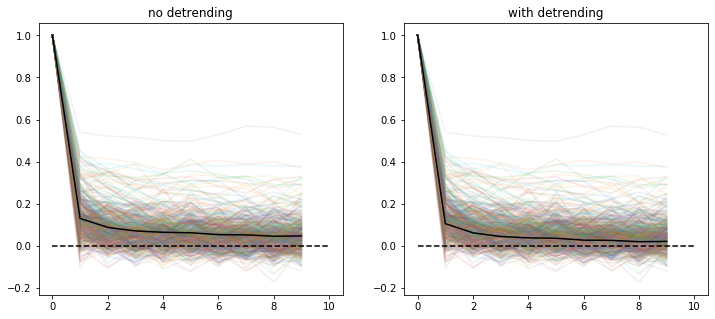

In [149]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
_ = plt.plot(acorrs.T, alpha=0.1)
plt.plot(np.mean(acorrs.T, 1), 'k')
plt.plot([0, 10], [0,0], 'k--')
plt.title('no detrending')
plt.subplot(1,2,2)
_ = plt.plot(acorrs.T, alpha=0.1)
plt.plot(np.mean(acorrs_detrend.T, 1), 'k')
plt.plot([0, 10], [0,0], 'k--')
plt.title('with detrending')


This small amount of autocorrelation should not have a major effect (especially after detrending), but is worth being aware of.  One would not want to use this kind of modeling for data with strong autocorrelation, such as fMRI data.  In principle one could use a linear model with a covariance structure that addresses this autocorrelation, but this is difficult in lmer; instead, one should look at the BRMS package, which allows one to easily specify an autocorrelation structure for mixed model.

## Two-level mixed effects modeling

With very large data and complex random slopes, estimating a multilevel model can become computationally challenging.  Within the fMRI literature, a multi-stage approach is often used instead of trying

### Item analysis

Generate synthetic data, after [Clark (1973)](https://web.stanford.edu/~clark/1970s/Clark,%20H.H.%20_Language%20as%20fixed%20effect%20fallacy_%201973.pdf):

Coleman's main point is best illustrated with
a simple example. Imagine that Baker and
Reader are two psychologists interested in
reading. Independently, they come up with
the hypothesis that people can read, that is,
perceive and vocalize, nouns faster than
verbs. To test their hypotheses, each consults
a dictionary, selects 10 nouns and I0 verbs
at random, and collects reading latencies for
the 20 words from each of 50 subjects. Let us
assume, however, that contrary to their
hypothesis nouns are in actuality exactly
equal to verbs in reading latencies. Nevertheless, since the actual latencies for individual
nouns and verbs vary from 500 to 1000 msec,
the nouns in any particular sample will not
be exactly equal to the verbs. So let us assume,
quite plausibly, that in Baker's sample the
nouns are actually 25 msec faster than the
verbs, while in Reader's there is a 25 msec
difference in the opposite direction. Independently, then, the two investigators tally
their results, Baker finding a 30 msec difference in favor of the hypothesis, and Reader, a
35 msec difference against it. And since 42
out of 50 subjects showed the difference for
Baker, and 45 out of 50 for Reader (both
differences significant at p < .001 by a sign
test), Baker reports to the public that he has
reliable support for the hypothesis, while
Reader reports that he has reliable evidence
against it. 




In [109]:
def generate_item_data(true_diff=0,
                       nitems = 20,
                       nsubs = 50,
                       sub_sd = 1,
                       item_sd = 1,
                       noise_sd=1,
                       seed=123):
    """
    generate simulated data for Clark (1973) example
    """
    rng = np.random.RandomState(seed=seed)
    verb = np.zeros(nitems)
    verb[:np.round(nitems/2).astype(int)] = 1
    # sample items
    item_effect = rng.randn(nitems)*item_sd + verb*true_diff
    # generate subject data
    subject_effect = rng.randn(nsubs)*sub_sd
    subject_effect = np.repeat(subject_effect[np.newaxis, :], nitems, 0).T
    
    subdata = np.repeat(item_effect[:, np.newaxis], nsubs, 1).T
    subdata = subdata + rng.randn(subdata.shape[0], subdata.shape[1])*noise_sd + subject_effect
    # make a long data frame
    subcodes =np.arange(1, nsubs+1)
    items = ['verb%02d' % i if i < np.round(nitems/2) else 'noun%02d' % i for i in range(nitems) ]
    subdata_long = subdata.reshape((nsubs*nitems, 1))
    items_long = items * nsubs
    subcodes_long = np.kron(np.array(subcodes), np.ones(nitems))
    category_long = [i[:4] for i in items_long]
    subdataDf = pd.DataFrame({'subject': subcodes_long,
                             'item': items_long,
                              'category': category_long,
                             'rt': subdata_long[:,0]})
    return(subdataDf)

itemdataDf = generate_item_data()

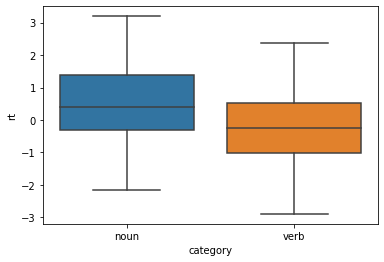

In [110]:
summaryDf = itemdataDf.groupby(['subject', 'category']).mean().reset_index() 
sns.boxplot(x='category', y='rt', data=summaryDf)

First let's run a standard analysis in which we don't take item effects into account, which will show a significant effect of word category:

In [111]:
item_fixed_model = smf.ols('rt ~ category', data=summaryDf)
result_fixed_model = item_fixed_model.fit()
result_fixed_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rt   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     9.296
Date:                Thu, 09 Apr 2020   Prob (F-statistic):            0.00295
Time:                        08:21:58   Log-Likelihood:                -155.79
No. Observations:                 100   AIC:                             315.6
Df Residuals:                      98   BIC:                             320.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4881      0.164      2.973      0.004       0.162       0.814
category[T.verb]    -0.7078      0.232     -3.049      0.003      -1.168      -0.247
==============================================================================
Omnibus:                        0.191   Durbin-Watson:                   0.898
Prob(Omnibus):                  0.909   Jarque-Bera (JB):                0.375
Skew:                           0.015   Prob(JB):                        0.829
Kurtosis:                       2.701   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model did not properly take into account the fact that items were sampled from a population, and thus should be treated as a random effect rather than a fixed effect. Let's now build a mixed effect model that properly does this, including a random effect of items as well as a random intercept and slope for subjects:

In [116]:
%%R -i itemdataDf
library(lme4)
library(lmerTest)
item_effect_model = lmer('rt ~ category + (1|item) + (1 + category|subject)', data=itemdataDf, REML=FALSE)
summary(item_effect_model)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: "rt ~ category + (1|item) + (1 + category|subject)"
   Data: itemdataDf

     AIC      BIC   logLik deviance df.resid 
  3049.8   3084.2  -1517.9   3035.8      993 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2469 -0.6069 -0.0380  0.6333  3.2090 

Random effects:
 Groups   Name         Variance Std.Dev. Corr 
 subject  (Intercept)  1.39396  1.1807        
          categoryverb 0.01994  0.1412   -0.95
 item     (Intercept)  1.41660  1.1902        
 Residual              0.95005  0.9747        
Number of obs: 1000, groups:  subject, 50; item, 20

Fixed effects:
             Estimate Std. Error      df t value Pr(>|t|)
(Intercept)    0.4881     0.4141 27.8923   1.179    0.248
categoryverb  -0.7078     0.5362 19.9826  -1.320    0.202

Correlation of Fixed Effects:
            (Intr)
categoryvrb -0.661


Now we see that once we have taken the random effects of items into account, the category effect is no longer significant.

## AOA example


In [9]:
aoa_dir = '/Users/poldrack/data_unsynced/wordbank/aoa-prediction/aoa_unified/'


In [37]:
%%R -i aoa_dir -o data_for_glmer

library(tidyverse)
library(lme4)
library(optimx)
load(paste(aoa_dir, 'saved_data/uni_model_data.RData', sep='/'))

predictors <- c("frequency", "MLU", "final_frequency", "solo_frequency",
    "num_phons", "concreteness", "valence", "arousal", "babiness")

by_lang_data <- uni_model_data %>%
  mutate(group = paste(language, measure),
         lexical_category = lexical_category %>% fct_relevel("other")) %>%
  select(language, measure, group, lexical_category, item = uni_lemma, prop,
         total, age, !!predictors) %>%
  group_by(language, measure) %>%
  nest()

eng_data <- by_lang_data %>%
  filter(language == "English (American)", measure == "understands") %>%
  pull(data) %>%
  .[[1]]

data_for_glmer <-   mutate(eng_data, lexical_category = lexical_category %>%
           fct_relevel("nouns", "function_words", "predicates"))

formula = "prop ~ (age | item) + age * frequency + age * MLU + age * final_frequency + 
    age * solo_frequency + age * num_phons + age * concreteness + 
    age * valence + age * arousal + age * babiness"

#ctrl = glmerControl(optimizer ='optimx', optCtrl=list(method='nlminb, maxit = 1e6'))
#ctrl = glmerControl(optimizer ='optimx', optCtrl=list(method='L-BFGS-B', maxit = 1e6))
#ctrl = glmerControl(optimizer ="Nelder_Mead")

eng_model_int_r <- glmer(
  formula,
  data_for_glmer,
  family = "binomial", weights = eng_data$total,
  contrasts = list(lexical_category = contr.sum)
)

summary(eng_model_int_r)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
prop ~ (age | item) + age * frequency + age * MLU + age * final_frequency +  
    age * solo_frequency + age * num_phons + age * concreteness +  
    age * valence + age * arousal + age * babiness
   Data: data_for_glmer
Weights: eng_data$total

     AIC      BIC   logLik deviance df.resid 
 28178.5  28325.1 -14066.3  28132.5     4300 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3452 -0.9087 -0.2282  0.5239  6.1093 

Random effects:
 Groups Name        Variance Std.Dev. Corr
 item   (Intercept) 1.05139  1.0254       
        age         0.04724  0.2173   0.08
Number of obs: 4323, groups:  item, 393

Fixed effects:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -1.2009376  0.0518746 -23.151  < 2e-16 ***
age                  1.1586492  0.0121121  95.661  < 2e-16 ***
frequency            0.3628488  0.07

R[write to console]: 
Correlation matrix not shown by default, as p = 20 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [33]:
seaborn.pl

,group,lexical_category,item,prop,total,age,frequency,MLU,final_frequency,solo_frequency,num_phons,concreteness,valence,arousal,babiness
1,English (American) understands,nouns,airplane,0.028571,35.0,-1.580956,-0.249901,-0.053293,0.509048,0.414471,0.845003,0.824251,-0.690939,1.965718,0.608298
2,English (American) understands,nouns,airplane,0.063830,94.0,-1.264765,-0.249901,-0.053293,0.509048,0.414471,0.845003,0.824251,-0.690939,1.965718,0.608298
3,English (American) understands,nouns,airplane,0.058065,155.0,-0.948574,-0.249901,-0.053293,0.509048,0.414471,0.845003,0.824251,-0.690939,1.965718,0.608298
4,English (American) understands,nouns,airplane,0.148936,94.0,-0.632382,-0.249901,-0.053293,0.509048,0.414471,0.845003,0.824251,-0.690939,1.965718,0.608298
5,English (American) understands,nouns,airplane,0.209790,143.0,-0.316191,-0.249901,-0.053293,0.509048,0.414471,0.845003,0.824251,-0.690939,1.965718,0.608298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4319,English (American) understands,other,zoo,0.053846,130.0,0.316191,-0.437098,1.065461,0.577544,-0.203810,-1.271694,0.670681,0.914390,1.977455,-0.121116
4320,English (American) understands,other,zoo,0.132231,121.0,0.632382,-0.437098,1.065461,0.577544,-0.203810,-1.271694,0.670681,0.914390,1.977455,-0.121116
4321,English (American) understands,other,zoo,0.159091,88.0,0.948574,-0.437098,1.065461,0.577544,-0.203810,-1.271694,0.670681,0.914390,1.977455,-0.121116
4322,English (American) understands,other,zoo,0.115385,78.0,1.264765,-0.437098,1.065461,0.577544,-0.203810,-1.271694,0.670681,0.914390,1.977455,-0.121116
